![MLTrain logo](https://mltrain.cc/wp-content/uploads/2017/11/mltrain_logo-4.png "MLTrain logo")

---------------------------------------------------------

In [1]:
%%capture --no-display
%run /Nvme/Training/MLTrainAthens/JupyterNotebooks/changeNBLayout.py

# %wget -q -O retailer.csv . . .

--------------------------
# Scope #

A large retailer asked for insights on the consumer purchasing preferences of their __fluid__ products.  
Fluids are products like shampoo, conditioner and cleaning liquids that are offered in packs of different sizes (weights | volumes).  
In particular, the retailer wanted to know  
1. the 
2. the consequences of __introducing a new size for a fluid product__  

  
<span style = "background: #E9B96E">
In the project we will investigate the effect of the <span style = "color: darkred">size composition of a sort__</span> to <b>sort sales</b>.
</span>  
A _sort_ is a collection of product items (SKUs) differing only in their sizes.

### Example ###
A type of H&S Shampoo if available in ounce-sizes 7 and 12. If I introduce a size 16oz what will be the effect on the sum of H&S sales?


# The retailer dataset #

The dataset contains numbers of items sold per week and store for each SKU.  
SKUs belong to BRANDS, SEGMENTS, TYPES and COLLECTIONS

In [2]:
import pandas as pd
import numpy as np
import sys, os
import datetime as dt

from os import linesep as endl

tab = pd.read_csv('retailer.csv', sep = '|')
display(tab.sample(10))

,SKU,GEO,WEEK_ENDING,WEEK,MONTH,PCT,PCTF,PCTD,UNITS,REVENUE,SEGMENT,TYPE,BRAND,COLLECTION,SORT,BASE_ITEM,SIZE
14898,102850,TWTUC,1982-04-29,17,4,93,0,0,6839,47500.34,CON,CR,H&S,H&SS&S,371,REG 1CT 23.0OZ,D
98515,101124,TTCTA,1984-11-01,44,11,95,0,0,2013,11741.84,SHA,SD,S,SPR,1043,DRY 2CT 4.3OZ,A
69231,104938,PTCTA,1985-12-05,49,12,82,0,0,715,2255.91,CON,CR,S,SPK,931,REG 1CT 12.6OZ,C
56951,102862,PTCTA,1984-08-09,32,8,75,0,0,642,2368.43,SHA,SR,S,SNA&S,860,REG 1CT 28.0OZ,D
66527,100422,TTCTA,1982-05-13,19,5,100,0,0,10170,31620.53,SHA,SR,S,SPK,928,REG 1CT 12.6OZ,C
86085,102096,TTCTA,1986-05-29,22,5,57,0,0,989,6812.30,SHA,S2,A,AA,988,2-IN-1 1CT 22.0OZ,D
22137,102518,TTCTA,1984-02-02,5,2,49,0,0,1203,6018.04,SHA,SR,H&S,H&SOL,384,REG 1CT 14.2OZ,C
25685,101998,WTCTA,1982-02-04,5,2,4,1,0,104,546.59,SHA,S2,H&S,H&S,387,2-IN-1 1CT 14.2OZ,C
21883,103679,TTCTA,1985-05-02,18,5,68,0,0,1384,10181.92,SHA,S2,H&S,H&SDS,361,2-IN-1 1CT 23.7OZ,D
24291,102083,PTCTA,1986-03-27,13,3,96,65,0,1437,7428.89,SHA,S2,H&S,H&SGA,385,2-IN-1 1CT 13.5OZ,C


How about the types of the data?

In [186]:
tab.dtypes

SKU              int64
GEO             object
WEEK_ENDING     object
WEEK             int64
MONTH            int64
PCTF             int64
PCTD             int64
UNITS            int64
REVENUE        float64
SEGMENT         object
TYPE            object
BRAND           object
COLLECTION      object
SORT             int64
BASE_ITEM       object
SIZE            object
dtype: object

Everything seems to have been read properly exept from WEEK_ENDING.  
It is a date column but has been read as string (type 'object' in DataFrames)

We can either re-read retailer.csv and explicitly parse WEEK_ENDING as date:
``` Python
pd.read_csv('retailer.csv', sep = '|', parse_dates = ['WEEK_ENDING'])
```
or we can convert the WEEK_ENDING column to datetime type using pandas.to_datetime function:

In [3]:
tab.WEEK_ENDING = pd.to_datetime(tab.WEEK_ENDING, format = '%Y-%m-%d')
print tab.WEEK_ENDING.dtype

datetime64[ns]


`DateFrame.describe` computes basic descriptive statistics of tab's contents

In [165]:
display(tab.describe())

,SKU,WEEK,MONTH,PCTF,PCTD,UNITS,REVENUE,SORT
count,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000,112779.000000
mean,102751.378555,24.961908,6.181816,4.534337,2.186657,5576.052102,19103.393757,689.939173
std,1504.111777,14.524046,3.341917,16.358580,5.421718,8459.402683,25958.044088,289.565226
min,100009.000000,1.000000,1.000000,0.000000,0.000000,5.000000,1.270000,356.000000
25%,101462.000000,13.000000,3.000000,0.000000,0.000000,638.000000,2676.925000,385.000000
50%,102862.000000,24.000000,6.000000,0.000000,0.000000,2539.000000,11185.930000,842.000000
75%,103837.000000,37.000000,9.000000,0.000000,2.000000,6998.500000,26853.630000,965.000000
max,105449.000000,52.000000,12.000000,99.000000,69.000000,131343.000000,715352.740000,2668.000000


-------------------------------------------------------
# An analysis of attribute relations #

There're several attributes that classify SKUs: SEGMENT, TYPE, BRAND, COLLECTION, SORT and BASE_ITEM  
We want to see if subsets of the attributes constitute dimension hierarchies.  
A dimension hierarchy is a set of attributes with a 1:N relation between them.  
  
E.g. if SEGMENT, BRAND, COLLECTION constitute a dimension hierarchy then SEGMENT:BRAND and BRAND:COLLECTION should be 1:N relations  

We can search for such relations per case, i.e search for a 1:N relation between SEGMENT and BRAND:

<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>

Do SEGMENT and BRAND constitute a dimension hierarchy?


Doing so explicitly for each pair of attributes in datasets with even a moderate number of attributes, is cumbersome and _leads to errors_.  
Instead, let's use Python's expressiveness to construct a representation of relations with a few lines of code:

In [4]:
def cardinals(df_):
    ret = pd.DataFrame(
        data = [], 
        index = pd.MultiIndex.from_product([df_.columns] * 2, names = ['groupby', '']),
        columns = ['nunique'])
    for row in df_.columns:
        ret.loc[row] = np.array([df_.groupby(row)[col].nunique().max() for col in df_.columns]).reshape(-1, 1)
    return ret.unstack()


cardinals(tab[['SEGMENT', 'TYPE', 'BRAND', 'COLLECTION']])

nunique                        
             BRAND COLLECTION SEGMENT TYPE
groupby                                   
BRAND            1         37       2    6
COLLECTION       1          1       2    5
SEGMENT          4         99       1    5
TYPE             4         76       1    1

In one stroke we see that BRAND:COLLECTION and SEGMENT:TYPE are dimension hierarchies

----------------------------------------------------------
# Creation of SIZE-related attributes #
The object is to see if the size composition of a SORT is related to total SORT sales.  
We must therefore create proxies of a sort's SIZE composition.
  
__SIZE_NUM__ = distinct sizes per GEO, WEEK_ENDING, SORT  
__SIZE_SORT__ = A (sorted) string representation of the available sizes per WEEK_ENDING, GEO, SORT
  
the second attribute tells us not only how many SIZEs we have in each SORT a given week but also the __kinds__ of available sizes:  
e.g. for SIZE_NUM = 3 we can have SIZE_SORT = 'ABC' or 'BDE'. These 2 sorts are not the same.

In [5]:
tab['NUM_SIZE'] = tab.groupby(['SORT', 'GEO', 'WEEK_ENDING'])['SIZE'].transform('nunique')
display(tab[tab['NUM_SIZE'] > 1][['SORT', 'GEO', 'WEEK_ENDING', 'NUM_SIZE']].sample(10))

,SORT,GEO,WEEK_ENDING,NUM_SIZE
27586,394,CTCT,1982-10-21,2
15958,374,CTCT,1982-08-19,2
2988,362,TTCTA,1983-03-31,2
29353,374,TTCTA,1983-06-30,2
46252,385,TTCTA,1985-03-28,2
28035,394,PTCTA,1986-06-19,2
35473,396,TWTUC,1982-12-09,2
19663,378,TTCTA,1985-12-12,2
22922,385,TWTUC,1985-09-05,2
90565,868,TWTUC,1985-01-10,2


`transform` is a convenience DataFrame method similar to `partition by` clauses in SQL.  
Applies a group transform to each row in the dataset, thereby creating new group columns  
  
------------------------
`SIZE_SORT` is trickier:  
We must gather the unique SIZES per SORT, concatenate them to create a string, than apply this string to each `['WEEK_ENDING', 'GEO', 'SORT']` group using `transform`.  
  
Fortunately Pandas is quite flexible in this (although not higly performant as you'll see), by permitting __custom functions in transformations__

In [6]:
%%timeit -n1 -r1
asSortedString = lambda _: ''.join(np.unique(_))

tab['SIZE_SORT'] = (tab.
    groupby(['WEEK_ENDING', 'GEO', 'SORT']).
    SIZE.
    transform(asSortedString))

1 loop, best of 1: 14 s per loop


In [199]:
display(tab.sample(10))

,SKU,GEO,WEEK_ENDING,WEEK,MONTH,PCT,PCTF,PCTD,UNITS,REVENUE,SEGMENT,TYPE,BRAND,COLLECTION,SORT,BASE_ITEM,SIZE,NUM_SIZE,SIZE_SORT
92598,103693,TWTUC,1983-11-24,47,11,93,0,4,5077,35256.21,SHA,S2,A,ADT,966,2-IN-1 1CT 22.0OZ,D,2,CD
92198,101952,TWTUC,1986-05-15,20,5,1,0,0,19,29.94,CON,CR,S,SPSE,1012,REG 1CT 28.0OZ,D,1,D
48161,101095,TTCTA,1986-05-08,19,5,13,0,0,109,1065.38,SHA,S2,H&S,H&SDS,361,2-IN-1 1CT 33.8OZ,E,3,CDE
67702,104490,TTCTA,1985-03-28,13,3,92,0,1,3811,9386.16,SHA,SR,S,SPK,929,REG 1CT 12.6OZ,C,2,CD
18298,102570,WTCTA,1982-05-20,20,5,38,0,1,907,4592.11,CON,CR,H&S,H&SIS,376,REG 1CT 13.5OZ,C,1,C
105105,101855,PTCTA,1982-08-05,31,8,93,0,10,4126,5155.35,SHA,SR,S,SEC,844,REG 1CT 30.0OZ,D,1,D
15842,105430,TWTUC,1982-03-04,9,3,94,0,7,7586,37428.41,SHA,S2,H&S,H&SHE,374,2-IN-1 1CT 14.2OZ,C,3,CDE
44475,102675,TTCTA,1985-01-31,5,1,64,0,0,1030,7616.67,SHA,S2,H&S,H&SIR,427,2-IN-1 1CT 22.5OZ,D,1,D
49688,100834,TWTUC,1984-05-03,18,5,95,0,15,16951,48501.61,SHA,SR,S,SPDM,494,REG 1CT 28.0OZ,D,2,CD
79371,104656,TTCTA,1985-10-17,42,10,74,0,0,2302,9154.26,SHA,S2,DM,DMT&S,984,2-IN-1 1CT 12.0OZ,C,2,CD


<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>  
Another interesting issue is the dependency a SORT may have on the number of available sizes in the SORT. E.g. assume that a product has 5 possible SIZES and 2 are only available.  
Is this the same as having 2 sizes for a product with 2 possible sizes?  
  
Create an attribute called PCT_SIZE per (GEO, WEEK_ENDING, SORT) that contains the % percentage in relation with the total number of sizes available for the SORT

-------------------------------------------------------------------------------------------
# Creation of UNITS and REVENUE related attributes #

### UNITS ###
The way retailer.csv provides the items sold per GEO and WEEK_ENDING (UNITS field) is cumbersome:  
  
1. GEO is not a store's location but a the name of a distribution channel!  
2. UNITS then, is the number of SKUs sold through a channel's stores (channels have different number of stores).  
3. There is no indication of the number of stores per channel. Rather the field PCT contains the __percentage__ of the stores in a channel that a given SKU was available in a certain WEEK_ENDING.  
  
The best we can do is assume that each channel has 100 stores and use the UNITS/PCT as a target variable in our prediction task.  
We can say that we predict the units sold per GEO's __percentile store__.  
  
We use Dataframe's `where` method to divide UNITS by non-zero PCT only

In [209]:
# DO NOT forget to convert to float:
# Both UNITS and PCT are int. Dividing them in Python 2.x produces an int that will truncate fractional sales

tab['SALES'] = np.where(tab.PCT > 0, (1. * tab.UNITS)/tab.PCT, 0.) 
print tab.SALES.dtype

dtype('float64')

### REVENUE ###
REVENUE contains the pounds collected from ALL the stores of the channel per SKU and WEEK_ENDING.  
Therefore is not sth that we can use during the prediction phase (we don't know the items sold).  
  
REVENUE/UNITS however is the avg selling price of the item and this is known during the prediction phase.

In [211]:
tab['PRICE'] = np.where(tab.UNITS > 0, tab.REVENUE / tab.UNITS, 0.)
print tab.PRICE.sample(5)

16704     0.977857
70513     1.577262
10039     4.928705
79662     5.560638
111454    1.978717
Name: PRICE, dtype: float64


------------
# EDA #

In [242]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context('notebook', font_scale = 1.2)

### Dataset imbalance:  ###
Observation counts per SEGMENT and {SIZE, NUM_SIZE, SORT_TYPE}: The dataset is highly biased towards sizes C and D, and sorts C, D and CD.  
Analysis will be constraint to categories with enough observations (here we will filter with SIZE_SORT C, D, CD and CDE)

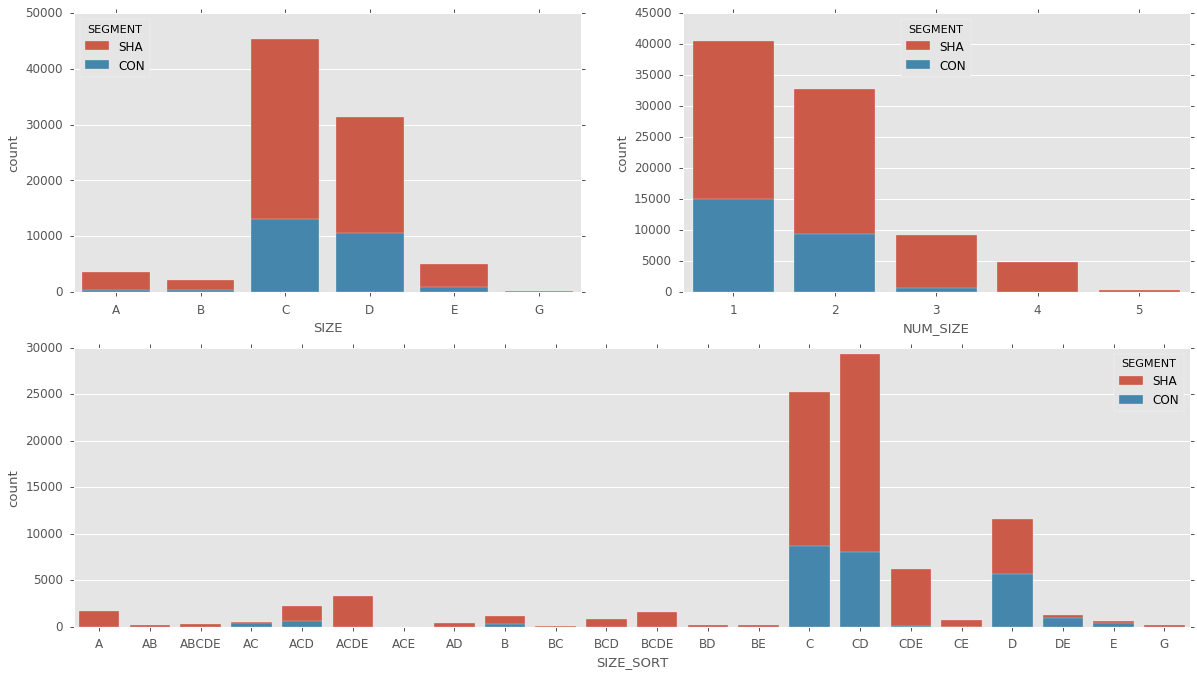

In [245]:
fig = plt.figure(figsize = [20, 11])
ax1 = fig.add_subplot(221)
sns.countplot(x = 'SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'SIZE'), ax = ax1, dodge = False)
ax2 = fig.add_subplot(222)
sns.countplot(x = 'NUM_SIZE', hue = 'SEGMENT', data = tab.sort_values(by = 'NUM_SIZE'), ax = ax2, dodge = False)
ax3 = fig.add_subplot(212)
sns.countplot(x = 'SIZE_SORT', hue = 'SEGMENT', dodge = False, ax = ax3, data = tab.sort_values(by = 'SIZE_SORT'))

Create (a reference to) a subset of tab, containing only the SIZE_SORT values of interest:

In [296]:
tab2 = tab[tab.SIZE_SORT.isin(['C', 'D', 'E', 'CD', 'CDE'])]

### Dependency of SALES to promotions ###
PCTF and PCTD are similar to PCT and contain the percentage of stores where a product was _'Featured'_ or _'Displayed'_.  
Both featuring and display can hold for a product.  
  
A __featured__ product is sold with an extra 'feature' like another complementary (e.g. shampoo with conditioner)  
A __displayed__ product is placed in a very 'spotty' location in the store  
  
In the following we examine the relation of PCTD with SALES and display this relationship visually and with a statistical descriptive measure called __'lift'__

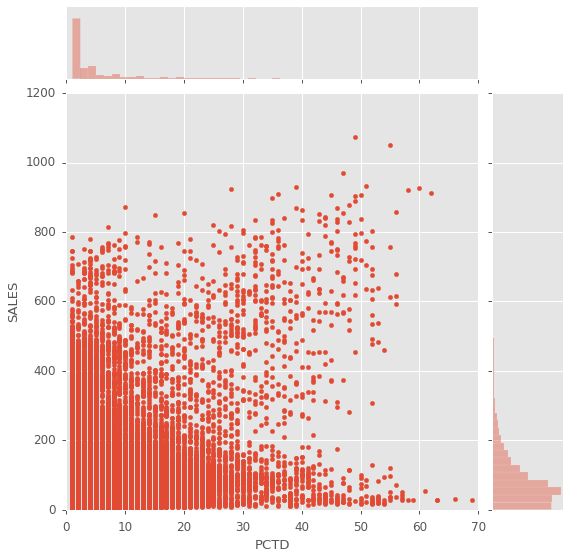

In [297]:
_ = sns.jointplot(x = 'PCTD', y = 'SALES', data = tab2[tab2.PCTD > 0.], size = 8, stat_func = None)

<span style = "color: darkred; font-size: 200%; font-weight: bold;  text-decoration: underline"> 
Exercise 
</span>  
  
A lift of a scalar quantity (here SALES) wrt a binary variable V is defined as:  
$$\frac{\mathtt {AVG(quantity)\, for\, V = 1}}{\mathtt {AVG(quantity)\, for\, V = 0}}$$

Calculate the lift of sales for PCTD > .2 versus PCTD <= .2


### Elaborating on PCTD ###
A question is whether this loose relation of PCTD to sales is general or holds for certain SIZES and SIZE_SORTS  
  
In the following diagram we display this relation per SIZE and SIZE_SORT for the conditioner and shampoo segments.  
It is shown that a general relation between PCTD and SALES is misleading and related to a specific brand.

In [304]:
tab2.dtypes
# fg = sns.FacetGrid(
    tab2,
    row = 'SIZE', col = 'BRAND', hue = 'SEGMENT', size = 2.5, aspect = 1.5)
# _ = fg.map(plt.scatter, 'SALES', 'SIZE_SORT')

IndentationError: unexpected indent (<ipython-input-304-e95d7ce27d2c>, line 3)